# Calculation of control fields for state-to-state transfer of a 2 qubit system using CRAB algorithm

Jonathan Zoller (jonathan.zoller@uni-ulm.de)

Example to demonstrate using the control library to determine control
pulses using the ctrlpulseoptim.optimize_pulse_unitary function.
The CRAB algorithm is used to optimize pulse shapes to minimize the fidelity
error, which is equivalent maximising the fidelity to an optimal value of 1.

The system in this example are two qubits, where the interaction can be
controlled. The target is to perform a pure state transfer from a down-down
state to an up-up state.

The user can experiment with the timeslicing, by means of changing the
number of timeslots and/or total time for the evolution.
Different initial (starting) pulse types can be tried as well as
boundaries on the control and a smooth ramping of the pulse when
switching the control on and off (at the beginning and close to the end).
The initial and final pulses are displayed in a plot

An in depth discussion of using methods of this type can be found in [1,2]

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import random

import qutip_qtrl.pulseoptim as cpo
from qutip import Qobj, identity, sigmax, sigmaz, tensor, about

example_name = "2qubitInteract"
%matplotlib inline

### Defining the physics

The dynamics of the system are governed by the combined Hamiltonian:
H(t) = H_d + sum(u1(t)*Hc1 + u2(t)*Hc2 + ....)
That is the time-dependent Hamiltonian has a constant part (called here the drift) and time vary parts, which are the control Hamiltonians scaled by some functions u_j(t) known as control amplitudes
In this example we describe an Ising like Hamiltonian, encompassing random coefficients in the drift part and controlling the interaction of the qubits:

$ \hat{H} = \sum_{i=1}^2 \alpha_i \sigma_x^i + \beta_i \sigma_z^i + u(t) \cdot \sigma_z \otimes \sigma_z $

Initial $\newcommand{\ket}[1]{\left|{#1}\right\rangle} \ket{\psi_0} = \text{U_0}$ and target state $\ket{\psi_t} = \text{U_targ}$ are chosen to be:

$ \ket{\psi_0} = \begin{pmatrix} 1 \\ 0 \\ 0 \\ 0 \end{pmatrix}$

$ \ket{\psi_t} = \begin{pmatrix} 0 \\ 0 \\ 0 \\ 1 \end{pmatrix}$

In [2]:
random.seed(20)
alpha = [random.random(), random.random()]
beta = [random.random(), random.random()]

Sx = sigmax()
Sz = sigmaz()

H_d = (
    alpha[0] * tensor(Sx, identity(2))
    + alpha[1] * tensor(identity(2), Sx)
    + beta[0] * tensor(Sz, identity(2))
    + beta[1] * tensor(identity(2), Sz)
)
H_c = [tensor(Sz, Sz)]
# Number of ctrls
n_ctrls = len(H_c)

q1_0 = q2_0 = Qobj([[1], [0]])
q1_targ = q2_targ = Qobj([[0], [1]])

psi_0 = tensor(q1_0, q2_0)
psi_targ = tensor(q1_targ, q2_targ)

### Defining the time evolution parameters

To solve the evolution the control amplitudes are considered constant within piecewise timeslots, hence the evolution during the timeslot can be calculated using U(t_k) = expm(-i*H(t_k)*dt). Combining these for all the timeslots gives the approximation to the evolution from an initial state $\psi_0$ at t=0 to U(T) at the t=evo_time.
The number of timeslots and evo_time have to be chosen such that the timeslot durations (dt) are small compared with the dynamics of the system.

In [3]:
# Number of time slots
n_ts = 100
# Time allowed for the evolution
evo_time = 18

### Set the conditions which will cause the pulse optimisation to terminate

At each iteration the fidelity of the evolution is tested by comparaing the calculated evolution U(T) with the target U_targ. For unitary systems such as this one this is typically:
f = normalise(overlap(U(T), U_targ)). The maximum fidelity (for a unitary system) calculated this way would be 1, and hence the error is calculated as fid_err = 1 - fidelity. As such the optimisation is considered completed when the fid_err falls below such a target value.

In some cases the optimisation either gets stuck in some local minima, or the fid_err_targ is just not achievable, therefore some limits are set to the time/effort allowed to find a solution.

The algorithm uses the CRAB algorithm to determine optimized coefficients that lead to a minimal fidelity error. The underlying optimization procedure is set to be the Nelder-Mead downhill simplex. Therefore, when all vertices shrink together, the algorithm will terminate.

In [4]:
# Fidelity error target
fid_err_targ = 1e-3
# Maximum iterations for the optisation algorithm
max_iter = 500
# Maximum (elapsed) time allowed in seconds
max_wall_time = 120

### Set the initial pulse type

The control amplitudes must be set to some initial values. Typically these are just random values for each control in each timeslot. These do however result in erratic optimised pulses. For this example, a solution will be found for any initial pulse, and so it can be interesting to look at the other initial pulse alternatives.

In [5]:
# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = "DEF"

### Give an extension for output files

In [6]:
# Set to None to suppress output files
f_ext = "{}_n_ts{}_ptype{}.txt".format(example_name, n_ts, p_type)

### Run the optimisation

In this step, the actual optimization is performed. At each iteration the Nelder-Mead algorithm calculates a new set of coefficients that improves the currently worst set among all set of coefficients. For details see [1,2] and a textbook about static search methods. The algorithm continues until one of the termination conditions defined above has been reached. If undesired results are achieved, rerun the algorithm and/or try to change the number of coefficients to be optimized for, as this is a very crucial parameter.

In [7]:
result = cpo.opt_pulse_crab_unitary(
    H_d,
    H_c,
    psi_0,
    psi_targ,
    n_ts,
    evo_time,
    fid_err_targ=fid_err_targ,
    max_iter=max_iter,
    max_wall_time=max_wall_time,
    init_coeff_scaling=5.0,
    num_coeffs=5,
    method_params={"xtol": 1e-3},
    guess_pulse_type=None,
    guess_pulse_action="modulate",
    out_file_ext=f_ext,
    gen_stats=True,
)

### Report the results

Firstly the performace statistics are reported, which gives a breakdown of the processing times. In this example it can be seen that the majority of time is spent calculating the propagators, i.e. exponentiating the combined Hamiltonian.

The optimised U(T) is reported as the 'final evolution', which is essentially the string representation of the Qobj that holds the full time evolution at the point when the optimisation is terminated.

The key information is in the summary (given last). Here the final fidelity is reported and the reason for termination of the algorithm.

In [8]:
result.stats.report()
print("Final evolution\n{}\n".format(result.evo_full_final))
print("********* Summary *****************")
print("Final fidelity error {}".format(result.fid_err))
print("Final gradient normal {}".format(result.grad_norm_final))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))
print(
    "Completed in {} HH:MM:SS.US".format(datetime.timedelta(seconds=result.wall_time))
)


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:08.144479
Wall time computing Hamiltonians: 0:00:00.279046 (3.43%)
Wall time computing propagators: 0:00:07.600826 (93.32%)
Wall time computing forward propagation: 0:00:00.068547 (0.84%)
Wall time computing onward propagation: 0:00:00.057184 (0.70%)
Wall time computing gradient: 0:00:00 (0.00%)

**** Iterations and function calls ****
Number of iterations: 270
Number of fidelity function calls: 409
Number of times fidelity is computed: 409
Number of gradient function calls: 0
Number of times gradients are computed: 0
Number of times timeslot evolution is recomputed: 409

**** Control amplitudes ****
Number of control amplitude updates: 408
Mean number of updates per iteration: 1.511111111111111
Number of timeslot values changed: 40798
Mean number of timeslot changes per update: 99.99509803921569
Number of amplitude values changed:

### Plot the initial and final amplitudes

Here the (random) starting pulse is plotted along with the pulse (control amplitudes) that was found to produce the target gate evolution to within the specified error.

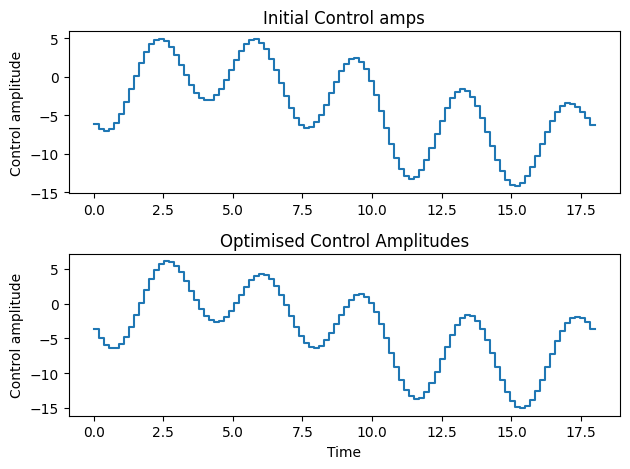

In [9]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(2, 1, 1)
ax1.set_title("Initial Control amps")
ax1.set_ylabel("Control amplitude")
ax1.step(
    result.time,
    np.hstack((result.initial_amps[:, 0], result.initial_amps[-1, 0])),
    where="post",
)

ax2 = fig1.add_subplot(2, 1, 2)
ax2.set_title("Optimised Control Amplitudes")
ax2.set_xlabel("Time")
ax2.set_ylabel("Control amplitude")
ax2.step(
    result.time,
    np.hstack((result.final_amps[:, 0], result.final_amps[-1, 0])),
    where="post",
)
plt.tight_layout()
plt.show()

### Versions

In [10]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.1.1
Numpy Version:      1.26.4
Scipy Version:      1.13.0
Cython Version:     3.0.10
Matplotlib Version: 3.9.0
Python Version:     3.12.3
Number of CPUs:     8
BLAS Info:          Generic
INTEL MKL Ext:      /home/rochisha/miniconda3/envs/qutip-dev/lib/libmkl_rt.so.2
Platform Info:      Linux (x86_64)
Installation path:  /home/rochisha/miniconda3/envs/qutip-dev/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------

### References

[1] Doria, P., Calarco, T. & Montangero, S.: Optimal Control Technique for Many-Body Quantum Dynamics. Phys. Rev. Lett. 106, 1–4 (2011).

[2] Caneva, T., Calarco, T. & Montangero, S.: Chopped random-basis quantum optimization. Phys. Rev. A - At. Mol. Opt. Phys. 84, (2011).